## import hazard data and plot, check

In [1]:
import geopandas as gpd
import pandas as pd
import GOSTnets as gn
import networkx as nx
import osmnx as ox

In [9]:
#https://epsg.io/3123
crs_manila = {'init': 'epsg:3123'}
crs_global = {'init': 'epsg:4326'}

In [3]:
cd /home/op/network_manila

/home/op/network_manila


In [4]:
G = nx.read_gpickle('data_osm_raw/manila_clean.pickle')

In [5]:
#import hazard data

liquefaction = gpd.read_file(r"hazard_data/Liquefaction/Liquefaction_MetroManila.shp")
faultline = gpd.read_file(r"hazard_data/ActiveFault/ActiveFault_MetroManila.shp")

In [6]:
liquefaction.crs, faultline.crs

({'init': 'epsg:4326'}, {'init': 'epsg:4326'})

In [10]:
#buffer around faultline (50 meters)

faultline["geometry_buffer50"] = faultline.geometry
faultline = faultline.set_geometry("geometry_buffer50")
faultline = faultline.to_crs(crs_manila)
faultline["geometry_buffer50"] = faultline.geometry.buffer(50)
faultline = faultline.to_crs(crs_global)


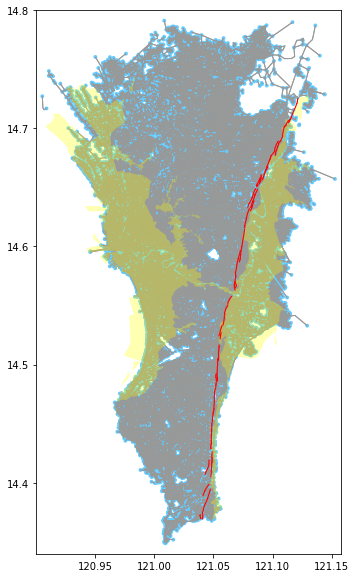

<Figure size 432x288 with 0 Axes>

In [18]:
G.graph.update( {'crs' : crs_global} )
G.graph.update( {'name' : 'manila'} )
fig, ax = ox.plot_graph(G, fig_height=10, axis_off=False, show=False)
faultline.plot(ax=ax, color='red', zorder=3)
liquefaction.plot(ax=ax, color='yellow', markersize=10, zorder=2, alpha=0.3)
fig

In [11]:
#import asset data

schools = gpd.read_file(r"asset_data/MetroManila/MetroManila/DepEd/SchoolLocation.shp")
hospitals = gpd.read_file(r"asset_data/MetroManila/MetroManila/DOH/HealthFacilities.shp")

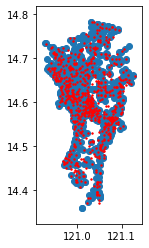

In [12]:
base=schools.plot()
hospitals.plot(ax=base, color='red', markersize=2)

In [13]:
len(schools), len(hospitals), schools.crs, hospitals.crs

(768, 734, {'init': 'epsg:4326'}, {'init': 'epsg:4326'})

## determine roads (network edges) affected by natural hazards

In [11]:
import shapely
from shapely.wkt import loads
from shapely.geometry import LineString, MultiLineString, Point


In [12]:
G_clip = nx.read_gpickle('data_osm_raw/manila_clean_clipped.pickle')

In [13]:
def tag_nodes_intersecting_gdf(G, gdf, property_name = 'intersects_gdf'):
    """
    this function tags each node of the graph which lies within the passed geodataframe's polygon
    note that graph and gdf must be in the same crs!
    :param G: a graph containing one or more nodes
    :param gdf: a geodataframe
    :param property_name: a property name for whether the node intersects the gdf
    :returns: a graph
    """

    G_copy = G.copy()
    
    if type(G_copy) == nx.classes.multidigraph.MultiDiGraph or type(G_copy) == nx.classes.digraph.DiGraph:
        pass
    else:
        raise ValueError('Expecting a graph or geodataframe for G!')

    # generate dictionary of {node ID: point} pairs
    try:
        list_of_nodes = {}
        for u, data in G_copy.nodes(data=True):
            list_of_nodes.update({u:(data['x'], data['y'])})
    except:
        raise ValueError('loading point geometry went wrong. Ensure node data dict includes x, y values!')

    # get gdf geometry
    try:
        gdf_geometry = gdf.unary_union
    except:
        raise ValueError('Expecting a geodataframe!')

    # create list of values, throw out nodes that don't intersect the gdf
    selKeys = []
    selPts = []
    for key, pt in list_of_nodes.items():
        if Point(pt[0], pt[1]).intersects(gdf_geometry):
            selPts.append(1)
            selKeys.append(key)

    # generate new dictionary of {node ID: 1 where 1 signals intersection}
    ref = dict(zip(selKeys, selPts))

    # load new values onto node data dictionary, set to 0 if not intersecting
    missedCnt = 0
    for u, data in G_copy.nodes(data=True):
        try:
            data[property_name] = ref[u]
        except:
            data[property_name] = 0
            missedCnt += 1
    print("Number of original nodes:", len(G_copy.nodes))
    print("Number of missed nodes gdf:", missedCnt)
    print("Number of nodes that intersect gdf:", len(selKeys))

    return G_copy

In [14]:
def tag_edges_intersecting_polygons(G, gdf, geometry_tag = "Wkt", xCol='x', yCol = 'y', 
                                    new_property_name = 'intersects_gdf' ):
    """
    Function for tagging edges of a graph that intersect polygon(s).
    !! Ensure Graph G and GeoDataFrame gdf are in the same projection before using function !!

    :param G: a Graph object
    :param gdf: a GeoDataFrame containing one or more polygons
    :param geometry_tag: the name of the Graph's edges' attribute holdings the geometry, if available
    :param xCol: if no shapely geometry but Longitude present, assign here
    :param yCol: if no shapely geometry but Latitude present, assign here
    :param new_property_name: the name of the edge property in the returned graph, containing 1 if edge intersects
            GDF and 0 if it does not
    :returns: the graph with edges intersecting polygons tagged with new_property_name = 1
    """
   
    G_copy = G.copy()
    
    if type(G_copy) == nx.classes.multidigraph.MultiDiGraph or type(G_copy) == nx.classes.digraph.DiGraph:
        pass
    else:
        raise ValueError('Expecting a graph for parameter G!')
       
    # get gdf geometry
    try:
        gdf_geometry = gdf.unary_union
    except:
        raise ValueError('Expecting a geodataframe for parameter gdf!')

    #collect stats
    edges_intersecting = 0
    edges_not_intersecting = 0
    
    #iterate through all edges of graph
    for u, v, data in G_copy.edges(data=True):
              
        # get geometry of node (and construct straight line if there is none)
        if geometry_tag in data:
            #if the geometry tag is Wkt we first have to load the geometry into shapely
            if geometry_tag == "Wkt":
                geom = loads(data[geometry_tag])
            #if there is already a geometry attribute, we can just use it
            else:
                geom = data[geometry_tag]
        else:
            # if it doesn't have a geometry attribute, we assume the edge is a straight
            # line from node to node
            x1 = G.nodes[u][xCol]
            y1 = G.nodes[u][yCol]
            x2 = G.nodes[v][xCol]
            y2 = G.nodes[v][yCol]
            geom = LineString([(x1, y1), (x2, y2)])
    
    
        #tag the edges that intersect the gdf with 1, and those that don't with a zero
        if geom.intersects(gdf_geometry) == True:
            data[new_property_name] = 1
            edges_intersecting += 1
        else:
            data[new_property_name] = 0
            edges_not_intersecting += 1
            
    print("Number of original edges:", len(G_copy.edges))
    print("Number of edges that intersect gdf:", edges_intersecting)
    print("Number of edges that don't intersect gdf:", edges_not_intersecting)

    
    return G_copy
    

In [15]:
G_clip_liq = tag_edges_intersecting_polygons(G_clip, gdf = liquefaction, geometry_tag = "Wkt", 
                                    new_property_name = 'intersects_liquefaction')

Number of original edges: 11367
Number of edges that intersect gdf: 4114
Number of edges that don't intersect gdf: 7253


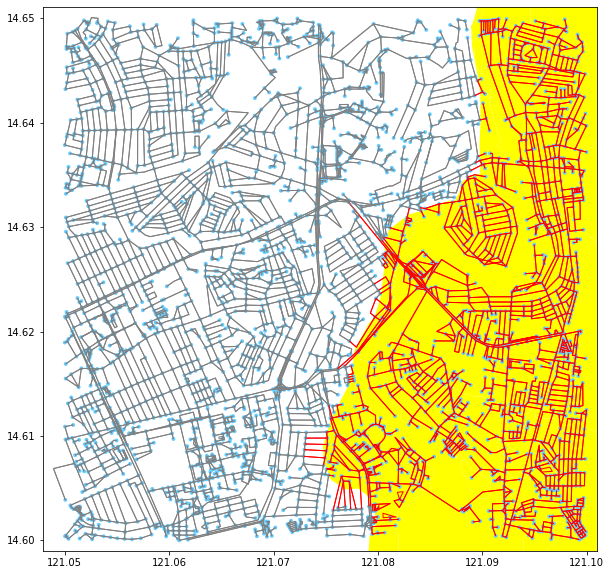

<Figure size 432x288 with 0 Axes>

In [18]:
G_clip_liq.graph.update( {'crs' : crs_global} )
G_clip_liq.graph.update( {'name' : 'manila'} )
nc = ['red' if data['intersects_liquefaction']==1 else 'grey' for u, v, data in G_clip_liq.edges(data=True)]
fig, ax = ox.plot_graph(G_clip_liq, fig_height=10, axis_off=False, show=False, edge_color=nc)
liquefaction.plot(ax=ax, color='yellow', zorder=0)
fig

In [16]:
G_clip_fault = tag_edges_intersecting_polygons(G_clip_liq, gdf = faultline, geometry_tag = "Wkt", 
                                    new_property_name = 'intersects_faultline')

Number of original edges: 11367
Number of edges that intersect gdf: 426
Number of edges that don't intersect gdf: 10941


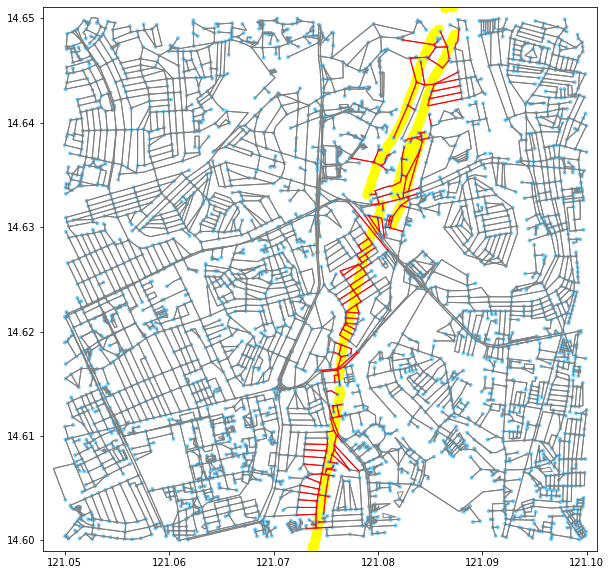

<Figure size 432x288 with 0 Axes>

In [17]:
G_clip_fault.graph.update( {'crs' : crs_global} )
G_clip_fault.graph.update( {'name' : 'manila'} )
nc = ['red' if data['intersects_faultline']==1 else 'grey' for u, v, data in G_clip_fault.edges(data=True)]
fig, ax = ox.plot_graph(G_clip_fault, fig_height=10, axis_off=False, show=False, edge_color=nc)
faultline.plot(ax=ax, color='yellow', zorder=0)
fig

## re-alculate road traverse times for disrupted network

In [35]:
def generate_new_time_attribute(G):
    """
    this function creates a new attribute in each node called time_disrupted which can later be modified
    :param G: a graph containing one or more nodes, with an edge property called "time" showing how
            long it takes to traverse this edge
    :returns: a graph
    """

    G_copy = G.copy()
      
    for u, v, data in G_copy.edges(data = True):

        data['time_disrupted'] = data['time']

    return G_copy


In [39]:
def disrupt_edges_slowdown(G,  edge_property, thresh, new_speed, length_column = "length"):
    """
    this function recalculates the time needed to traverse all edges that satisfy a specified condition 
    NOTE that the unit of new_speed must correspond to the unit of length_column, e.g. m/s if length is in m
    :param G: a graph containing one or more nodes, with an edge property called "time_disrupted" showing how
            long it takes to traverse this edge before disruption that is then modified
    :param edge_property: a string, the propoerty name of the edge on which to check whether the edge should be modified
    :param thresh: a number. the threshold of edge_property above which to modify the edge speed
    :param new_speed: a number, the speed with which edges satisfying the disruption condition can now be traversed
    :param length_column: a string, the name of the column propoerty containing the length of each edge
    :returns: a graph with modified edge property time_disrupted
    """

    G_copy = G.copy()
  
    edges_disrupted = 0
    edges_not_disrupted = 0
    
    for u, v, data in G_copy.edges(data = True):

        if data[edge_property] > thresh:
            
            data['time_disrupted'] = data[length_column] * new_speed
            edges_disrupted+=1
        else:
            edges_not_disrupted+=1

    print("Number of edges:", len(G_copy.edges))
    print("Number of edges slowed down:", edges_disrupted)
    print("Number of edges not disrupted:", edges_not_disrupted)

    return G_copy


In [40]:
def disrupt_edges_fully(G, edge_property, thresh, fail_value):
    """
    this function sets the time_disrupted value of all edges to fail_value if they satisfy the specified condition
    :param G: a graph containing one or more nodes, with an edge property called "time_disrupted" showing how
            long it takes to traverse this edge before disruption that is then modified
    :param edge_property: a string, the propoerty name of the edge on which to check whether the edge should be modified
    :param thresh: a number. the threshold of edge_property above which to modify the edge speed
    :param fail_value: a number, the time it takes to traverse the edges that satisfy the condition after disruption 
    NOTE: usually very high so that the edge is never chosen in a trip calculation
    :returns: a graph with modified edge property time_disrupted
    """

    G_copy = G.copy()
  
    edges_disrupted = 0
    edges_not_disrupted = 0
    
    for u, v, data in G_copy.edges(data = True):

        if data[edge_property] > thresh:
            
            data['time_disrupted'] = fail_value
            edges_disrupted+=1
        else:
            edges_not_disrupted+=1


    print("Number of edges:", len(G_copy.edges))
    print("Number of edges set to fail value:", edges_disrupted)
    print("Number of edges not disrupted:", edges_not_disrupted)

    return G_copy


In [41]:
G_disrupted = generate_new_time_attribute(G_clip_fault)


Note that the order of calling the two next function determines what happens to edges that are affected by both types of hzards - here they are set to fail_value

In [42]:
liquefaction_speed_kmh = 7
liquefaction_speed_mps = liquefaction_speed_kmh / 3.6

G_disrupted = disrupt_edges_slowdown(G_disrupted,  node_property = "intersects_liquefaction", 
                                     thresh = 0.5, new_speed = liquefaction_speed_mps, length_column = "length")


Number of edges: 11367
Number of edges slowed down: 4114
Number of edges not disrupted: 7253


In [43]:
G_disrupted = disrupt_edges_fully(G_disrupted, node_property = "intersects_faultline", 
                                           thresh = 0.5, fail_value = 999999999)


Number of edges: 11367
Number of edges set to fail value: 426
Number of edges not disrupted: 10941


In [46]:
gn.save(G_disrupted,'manila_clean_clipped_disrupted','data_osm_raw')

### gn bugs 

- function graph_edges_intersecting_polygon(G, polygons, mode, crs = None, fast = True) specifies moode= 'intersecting' as param, but checks for 'intersects' -> fix: change string which is checked

- function clip doesn't work because shapely isn't imported -> fix: import shapely
- function clip doesn't work with new networkx -> fix: use nx.strongly_connected_components instead (see clip_new())

-> report these at some point

### functions developed here which might be useful to add to gostnets library:

- calculate_edge_lengths()
- tag_edges_intersecting_polygons(); tag_nodes_intersecting_polygons()
- disrupt_edges_slowdown(); disrupt_edges_fully()
- create_point_grid() (but maybe too far from core functionality)
- calculate_OD_with_startend()